In [1]:
import numpy as np
import gym
from tqdm import tqdm
import random as rand
from itertools import count

In [2]:
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from random import seed
from sklearn import preprocessing
from torch.nn.init import kaiming_uniform_#seed(1)

In [3]:
env = gym.make("CartPole-v0")

In [4]:
class ReplayMemory():
    def __init__(self,capacity):   
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count%self.capacity] = experience
        self.push_count+=1
    
    def sample(self, batch_size):
        return rand.sample(self.memory,batch_size)
    
    def can_provide_sample(self, batch_size):
        return len(self.memory)>=batch_size

In [5]:
def extract_tensors(experiences):
    batch = Xp(*zip(*experiences))
    state = np.stack(batch.state) #stack
    action = np.stack(batch.action)
    next_state = np.stack(batch.next_state)
    reward = np.stack(batch.reward)
    done = np.stack(batch.done)
    return state,action,next_state,reward,done

In [6]:
from collections import namedtuple
Xp = namedtuple('Experience',
                        ('state', 'action', 'next_state', 'reward', 'done'))
Xp_points = Xp(5,6,7,8,9)
Xp_points

Experience(state=5, action=6, next_state=7, reward=8, done=9)

In [7]:
class linearApproximator(nn.Module):
    def __init__(self,state_shape,n_fc1,n_fc2, action_n):
        super(linearApproximator, self).__init__()
        self.input_size = state_shape
        self.n_fc1 = n_fc1
        self.n_fc2 = n_fc2
        self.out = action_n
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.fc1  = nn.Linear(self.input_size,self.n_fc1)
        self.fc2  = nn.Linear(self.n_fc1,self.n_fc2)
        self.fc3  = nn.Linear(self.n_fc2,self.out)
        self.to(self.device)
        
    def forward(self, state_shape):
        x = self.fc1(state_shape)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        out = self.fc3(x)
        return out

In [8]:
#update target model after n timesteps
def update_target_network(target_network, online_network):
    target_network.load_state_dict(online_network.state_dict())
    return target_network

In [9]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False
    return model

In [10]:
def select_action(state, model, epsilon):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    state = torch.tensor(state).float()
    with torch.no_grad():
        q_values= model(state).cpu().detach()
        q_values = q_values.data.numpy().squeeze()
    if np.random.rand() > epsilon:
        action = np.argmax(q_values)
    else:
        action = np.random.randint(len(q_values))
    return action

In [11]:
def update_online_model(experience_samples, online_network, target_network, gamma, optimizer):
    states, actions, next_states, rewards, done = extract_tensors(experience_samples)
    
    states = torch.tensor(states).float()
    actions = torch.tensor(actions)
    actions = actions.type(torch.LongTensor)
    actions = actions.unsqueeze(1)
    next_states=torch.tensor(next_states).float()
    rewards = torch.tensor(rewards).float()
    done = torch.tensor(done).float()
    
    
    q_online_next_states = online_network(next_states)#we now take next_states from online network 
    q_online_next_states = q_online_next_states.max(1)[1]#we now take the indices and not the values from online network
    q_online_next_states = q_online_next_states.unsqueeze(1)#iindices
     
    
    q_target_next_states_action = target_network(next_states)
    q_target_next_states_action = q_target_next_states_action.detach()#always make sure detach on target net
    q_target_next_states_action = q_target_next_states_action.gather(1, q_online_next_states)
    #print(q_target_next_states_action.shape)
    done = done.unsqueeze(1)
    
    #print(q_target_next_states_action.shape, done.shape)
    
    q_target_next_states_action *=(1 - done) 
    rewards = rewards.unsqueeze(1)
    q_target = rewards + (gamma*q_target_next_states_action)
    
    
    q_online_state = online_network(states)
    q_online_state = q_online_state.gather(1, actions)
    
    q_u_loss = torch.nn.SmoothL1Loss()
    q_u_loss = q_u_loss(q_online_state,q_target)
    
    optimizer.zero_grad()
    q_u_loss.backward()
    optimizer.step()
    return online_network, target_network

In [12]:
def epsilon_decay_linear(init_eps, min_eps, decay_ratio, timestep, timestep_max):
    #timestep_max = (timestep + 1)*100000
    decay_t_step = timestep_max*decay_ratio
    epsilon = 1 - timestep/decay_t_step
    epsilon *= init_eps-min_eps
    epsilon+=min_eps
    epsilon = np.clip(epsilon, min_eps, init_eps)
    return epsilon

In [14]:
def DDQN_(env,
         gamma=0.9,
         memory_size = 50000,
         init_epsilon=1.0,
         min_epsilon=0.3,
         epsilon_decay_ratio=0.4,
         min_sample_size=320,
         batch_size = 64,
         n_ep=20000,
         target_update=15,
         max_t_steps = 100000):
    
    action_space = env.action_space.n
    state = env.reset()
    
    online_net = linearApproximator(len(state), 512, 128, action_space)
    target_net = linearApproximator(len(state), 512, 128, action_space)
    
    target_net.load_state_dict(online_net.state_dict())
    target_net.eval()
    target_net = freeze_model(target_net)
    optimizer = torch.optim.RMSprop(online_net.parameters(),lr=0.0007)
    
    memory = ReplayMemory(memory_size)
    
    t_step = 0 #important
    reward_per_ep = []
    
    for e in tqdm(range(n_ep)):
        state = env.reset()
        curr_reward = 0
        while True:
            epsilon = epsilon_decay_linear(init_epsilon, min_epsilon, epsilon_decay_ratio, t_step, max_t_steps)
            action = select_action(state, online_net, epsilon)
            next_state, reward, done, info = env.step(action)
            is_truncated = 'TimeLimit.truncated' in info and\
                                info['TimeLimit.truncated']
            is_failure = done and not is_truncated
            curr_reward+=reward
            memory.push(Xp(state,action,next_state,reward,is_failure))
            t_step+=1
            state = next_state
            
            if t_step >= max_t_steps:
                return reward_per_ep,online_net
            
            if memory.can_provide_sample(min_sample_size):
                experience_samples = memory.sample(batch_size)
                online_net, target_net =  update_online_model(experience_samples, online_net, target_net, gamma, optimizer)
                
            if t_step % target_update == 0:
                target_net = update_target_network(target_net, online_net)
                #print(t_step)
            if done == True:
                reward_per_ep.append(curr_reward)
                break    
        
            
    return reward_per_ep,online_net

In [15]:
reward, network_ = DDQN_(env)

 15%|███████████▉                                                                 | 3089/20000 [07:41<42:04,  6.70it/s]


In [25]:
from scipy.ndimage.filters import uniform_filter1d
arr = uniform_filter1d(reward, size=10)

In [26]:
from matplotlib import pyplot as plt
x = []
y = []
for i,e in enumerate(arr):
    y.append(i)
    x.append(e)

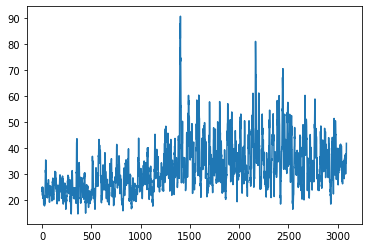

In [27]:
plt.plot(y, x)

In [ ]:
plt.plot(y, x)

In [ ]:
torch.nn.functional.huber_loss()

In [ ]:
import gym

env = gym.make('CartPole-v0')
env.reset()

for _ in range(1000):
    env.render()
    env.step(env.action_space.sample())
env.close()

In [ ]:
def loop3():
    for b in range(0, 6):
        for a in range(0, 6):
            print(b, a)
            if a == 3:
            # We found a three, let's end the function and "go back"
                return

In [ ]:
loop3()

In [15]:
env._max_episode_steps

200